### Загрузка библиотек

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import style
from sklearn import ensemble
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, GridSearchCV
from datetime import datetime
from pylab import rcParams

style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Загрузка данных

In [50]:
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')

In [51]:
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [52]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

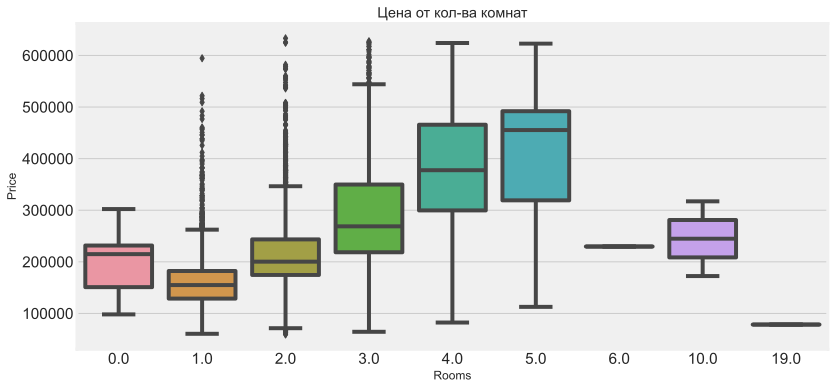

In [53]:
plt.figure(figsize=(12, 6))
sns.boxplot(train_data['Rooms'], train_data['Price'])
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Цена от кол-ва комнат')
plt.show()

### Отсекание лишних данных (оставим только числовые знчения)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ED022294C0>,
      dtype=object)

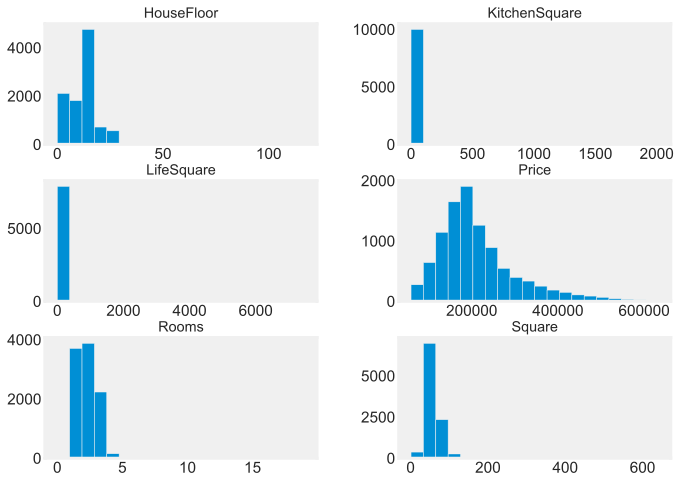

In [54]:
df_numerical_data = train_data.select_dtypes(include='float64')

num_data = pd.DataFrame(df_numerical_data)
num_data.drop('Ecology_1', axis=1, inplace=True)
num_data.drop('Healthcare_1', axis=1, inplace=True)
num_data.hist(figsize=(10, 8), bins=20, grid=False)

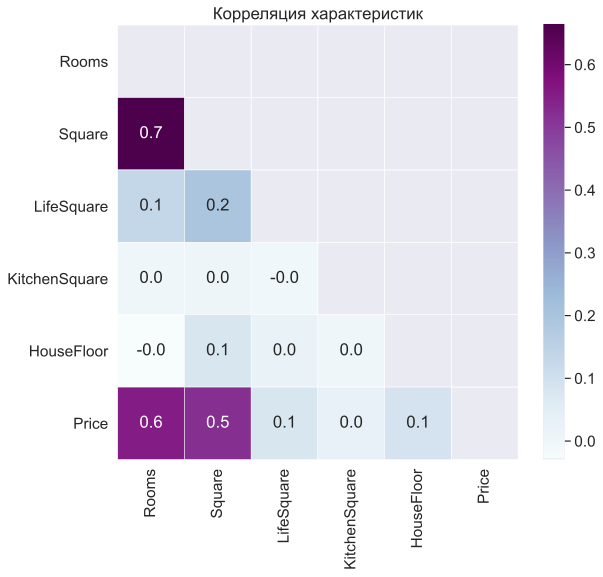

In [26]:
corr = num_data.corr()
plt.figure(figsize = (8, 8))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_data.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='BuPu')
plt.title('Корреляция характеристик')
plt.show()

### Финальная предобработка данных (проверка данных и заполнение пропусков)

In [55]:
train_data = train_data.sort_values('Price')
test_data = test_data.sort_values('DistrictId')
train_data = train_data.fillna(method='pad')
test_data = test_data.fillna(method='pad')

In [56]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 4561 to 51
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   5000 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2

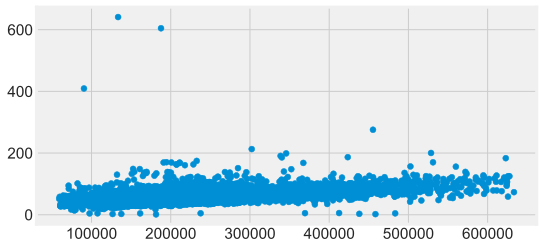

In [57]:
rcParams['figure.figsize'] = 8, 4

plt.scatter(train_data.Price, train_data.Square)

### Модель

In [1]:

X_train = train_data.drop('Price', axis=1) 
y_train = train_data['Price'] 

X_test = test_data 

pr = pd.DataFrame()
pr['Id'] = X_test['Id'].copy() 

del_list = ["Id", "DistrictId", "LifeSquare", "Healthcare_1", "Ecology_2", "Ecology_3", "Shops_2"]
X_train.drop(del_list, axis=1, inplace=True) 
X_test.drop(del_list, axis=1, inplace=True) 


model = RandomForestRegressor(n_estimators=1000, max_depth=16, random_state=42, max_features=7)
model.fit(X_train, y_train) 

y_pred = model.predict(X_test) 

pr['Price'] = y_pred 
pr.to_csv('EMesyatsev_predictions.csv', index=False)

NameError: name 'train_data' is not defined